# DataLab Cup 2: CNN for Object Detection

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)

In [3]:
!nvidia-smi

Sat Nov 20 14:54:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 40%   56C    P5    13W / 250W |     16MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 52%   

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        # for gpu in gpus:
        #     tf.config.experimental.set_memory_growth(gpu, True)
        #     tf.config.experimental.set_visible_devices(gpu[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Select GPU number 1
        # tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


2021-11-20 14:54:49.605978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 14:54:49.606300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 14:54:49.628448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 14:54:49.628769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 14:54:49.628946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [5]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [6]:
training_data_file = open("./dataset/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


## Hyperparameters

In [7]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 1
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './dataset/pascal_voc_training_data.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 10

## Dataset Loader

In [8]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

## Object Detection Model (YOLO)

### Model

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [11]:
# img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# x = conv_leaky_relu(img_inputs, 64, 7, 2)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 192, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 128, 1, 1)
# x = conv_leaky_relu(x, 256, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 2)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.Flatten()(x)
# x = layers.Dense(4096, 
#                  kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
# x = layers.LeakyReLU(0.1)(x)
# outputs = layers.Dense(1470, 
#                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

# YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [12]:
# YOLO.summary()

In [23]:
# ResNet50
#IMAGE_SIZE = 448
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet',classes=20)
base_model.trainable = False

inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(1024)(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470)(x)

resnet50 = keras.Model(inputs=inputs, outputs=outputs, name="ResNet50")
resnet50.summary()


Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 14, 14, 1024)      7037504   
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 1024)      9438208   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 1024)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 1024)      9438208   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 1024)      0         
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0  

### Define loss

In [24]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [25]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [26]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

### Start training

In [27]:
dataset = DatasetGenerator().generate()

In [28]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [29]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=resnet50)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=3,
                                     checkpoint_name='yolo')


# CKP_DIR = 'checkpoints'
# init_epoch = 1

# ckp = tf.train.latest_checkpoint(CKP_DIR)
# if ckp:
#     resnet50.load_weights(ckp)
#     init_epoch = int(ckp.split('_')[-1]) + 1
#     print(f'Resume training from epoch {init_epoch-1}')

In [30]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = resnet50(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, resnet50.trainable_weights)
    optimizer.apply_gradients(zip(grads, resnet50.trainable_weights))

In [31]:
from datetime import datetime

In [32]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2021-11-20 14:55:17.265839, start training.


2021-11-20 14:55:23.191484: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
2021-11-20 14:55:23.369766: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-20 14:55:23.763840: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-20 14:55:23.767493: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-20 14:55:24.318887: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.3

2021-11-20 15:02:02.726414, Epoch 1: loss 16.57


2021-11-20 15:02:02.974488: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 1: ./ckpts/YOLO/yolo-1
2021-11-20 15:08:42.473794, Epoch 2: loss 10.55


2021-11-20 15:08:42.613356: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 2: ./ckpts/YOLO/yolo-2
2021-11-20 15:15:22.954166, Epoch 3: loss 8.62


2021-11-20 15:15:23.089505: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 3: ./ckpts/YOLO/yolo-3
2021-11-20 15:22:02.625170, Epoch 4: loss 7.52


2021-11-20 15:22:02.760301: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 4: ./ckpts/YOLO/yolo-4
2021-11-20 15:28:42.095155, Epoch 5: loss 6.88


2021-11-20 15:28:42.230565: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.


Saved checkpoint for epoch 5: ./ckpts/YOLO/yolo-5
2021-11-20 15:35:21.593947, Epoch 6: loss 6.48
Saved checkpoint for epoch 6: ./ckpts/YOLO/yolo-6
2021-11-20 15:42:01.165291, Epoch 7: loss 6.20
Saved checkpoint for epoch 7: ./ckpts/YOLO/yolo-7
2021-11-20 15:48:40.582307, Epoch 8: loss 6.21
Saved checkpoint for epoch 8: ./ckpts/YOLO/yolo-8
2021-11-20 15:55:20.095768, Epoch 9: loss 5.71
Saved checkpoint for epoch 9: ./ckpts/YOLO/yolo-9
2021-11-20 16:01:59.540902, Epoch 10: loss 5.76
Saved checkpoint for epoch 10: ./ckpts/YOLO/yolo-10


### Predict test data

In [33]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [34]:
test_img_files = open('./dataset/pascal_voc_testing_data.txt')
test_img_dir = './dataset/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1
    
    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [36]:
ckpt = tf.train.Checkpoint(net=resnet50)
ckpt.restore('./ckpts/YOLO/yolo-10')

In [37]:
@tf.function
def prediction_step(img):
    return resnet50(img, training=False)

### Make prediction and output to txt file

In [38]:
output_file = open('./output/test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):

        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        # print("First:", xmin, ymin, xmax, ymax, class_num)
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
        # print("Second:", xmin, ymin, xmax, ymax, class_num)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

### Run evaluation metric

In [39]:
import sys
sys.path.insert(0, './evaluate')

In [40]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./output/test_prediction.txt', './output/output_file.csv')

End Evalutation


## Visualization

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

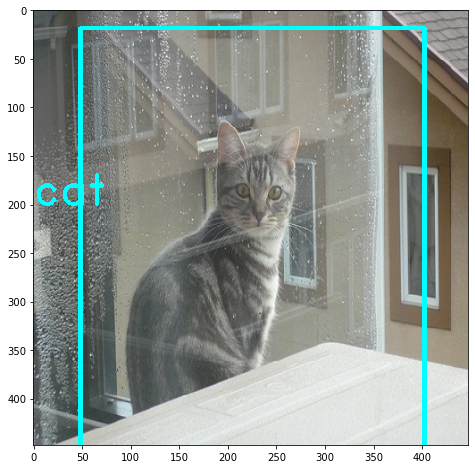

In [50]:

np_img = cv2.imread('./dataset/VOCdevkit_test/VOC2007/JPEGImages/000119.jpg')
resized_img = cv2.resize(src=np_img, dsize=(IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = resnet50(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.figure(figsize=(8,8))
plt.imshow(resized_img)
plt.show()